The goal of this project is to implement a digit classification neural network that will predict a handwritten digit between the values 0 and 9. The images used to train and validate te model will come from the **MNIST** dataset which is a public dataset of 28x28, grayscale, and handwritten image.

In [1]:
import numpy as np
import pandas as pd
import opendatasets as od   # For grabbing our dataset
from matplotlib import pyplot as plt    # Mainly used to display the images 

Let's start by grabbing the dataset.

In this example, we will be using the MNIST dataset from Kaggle, so we will need an account and a `kaggle.json` that will give us permission to download the dataset.

In [2]:
od.download("https://www.kaggle.com/competitions/digit-recognizer/data")

Skipping, found downloaded files in ".\digit-recognizer" (use force=True to force download)


Great, let's take the data and save them as `pandas` objects.

In [3]:
raw_train_data = pd.read_csv("digit-recognizer/train.csv")
raw_test_data = pd.read_csv("digit-recognizer/test.csv")

Let's take a look at the data.

In [4]:
raw_train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Currently the data are saved as `pandas` objects. Let's make them `numpy` arrays so we can do mathmatical operations on them.

In [5]:
train_data = np.array(raw_train_data)
test_data = np.array(raw_test_data)
rows, cols = train_data.shape   # show the number of examples and features
print(f"Examples: {rows}")
print(f"Features: {cols}")

Examples: 42000
Features: 785


Currently our data is reflecting 42000 examples with 784 features (pixels) each. We should transpose this data so that we the rows and columns represents features and data respecitively.

In [6]:
train_data = train_data.T
test_data = test_data.T
print(f"Shape of the first example in the training: {train_data.shape}")

Shape of the first example in the training: (785, 42000)


Great, our data is now features x examples. 

Since our labels are still mixed within the features of the data, lets make sure we take keep the inputs and labels apart. We will have a `X` that will be of shape features x examples and a `Y` that will have the shape equivilent to the number of examples we have.

In [7]:
Y_train = train_data[0]
X_train = train_data[1:]
X_train = X_train / 255

Y_test = test_data[0]
X_test = test_data[1:]
X_test = X_test / 255

print(f"Shape of training inputs: {X_train.shape}")
print(f"Shape of training labels: {Y_train.shape}")

Shape of training inputs: (784, 42000)
Shape of training labels: (42000,)


With our data all cleaned up, we can begin making our neural network.

We will be making a 3 layered, 1 hidden layer neural network.

- input layer
- hidden layer
- output layer

For the input and hidden layers, they will need their own weights and biases where the shapes are:

- weight = number_of outputs x number_of_inputs
- bias = number_of outputs x 1

In [8]:
def init_params():
    w1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    w2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return w1, b1, w2, b2

Now we make our forward propagation logic. Our input and hidden layer will perform the same linear operation on their inputs, but they will have different activation functions before passing their results to the next layer.

Our linear operation will be $weights * inputs + bias$ where we are getting the dot product between the weight and input matrix. 

For our input layer, we will use the ReLU activation and for our hidden, we will use the sigmoid activation.

In [9]:
def ReLU(z):
    return np.maximum(z, 0)

def softmax(z):
    return np.exp(z) / sum(np.exp(z))

def forward_prop(w1, b1, w2, b2, X):
    # Input layer
    z1 = w1.dot(X) + b1
    a1 = ReLU(z1)   # ReLU activation

    # Hidden layer
    z2 = w2.dot(a1) + b2
    a2 = softmax(z2)    # Sigmoid activation
    return z1, a1, z2, a2

The next component we need is backpropagation that will go back through our neural network and update the weights and bias according to the output. To achieve this, we need to accomplish a few tasks.

1. One hot encode `Y` (he process of representing categorical data as 0s and 1s)
2. Get the error of each outputed layer (hidden and ouput)
3. Get the gradients of the cost function with respect to the weights and biases of that layer
4. Update the weigths and biases with the gradients

In [10]:
def deriv_ReLU(z):
    return z > 0

def one_hot(Y):
    """
    This function follows these steps:
    1. make a matrix of all 0s of size [examples x labels]
    2. Generate an array of numbers 0 -> 41999.
    3. By using the array of numbers to go through the rows in the 0s matrix
       and Y to go through the columns, set that value to 1
    4. Transpose the modified 0s matrix
    """
    one_hot_Y = np.zeros((Y.size, Y.max() + 1)) 
    one_hot_Y[np.arange(Y.size), Y] = 1 # Steps 2 and 3
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def back_prop(z1, a1, z2, a2, w1, w2, X, Y):
    m = Y.size
    one_hot_Y = one_hot(Y)
    
    dz2 = a2 - one_hot_Y            # Get the error of the output layer
    dw2 = 1 / m * dz2.dot(a1.T)     # Get the gradient of the cost function with respect to the weights of the second layer
    db2 = 1 / m * np.sum(dz2)    # Get the gradient of the cost function with respect to the bias of the second layer

    dz1 = w2.T.dot(dz2) * deriv_ReLU(z1)    # Get the error of the hidden layer
    dw1 = 1 / m * dz1.dot(X.T)              # Get the gradient of the cost function with respect to the weights of the first layer
    db1 = 1 / m * np.sum(dz1)            # Get the gradient of the cost function with respect to the bias of the first layer
    return dw1, db1, dw2, db2

def update_params(w1, b1, w2, b2, dw1, db1, dw2, db2, alpha):
    w1 = w1 - alpha * dw1
    b1 = b1 - alpha * db1
    w2 = w2 - alpha * dw2
    b2 = b2 - alpha * db2
    return w1, b1, w2, b2

Great, with backpropagation and param updation working, we now have a way to modify our weights and biases which is the foundation for training. Now we need to implement **gradient descent** so we can keep adjusting these weights properly over multiple interations.

In [11]:
def get_predictions(a2):
    return np.argmax(a2, 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, iterations, alpha):
    w1, b1, w2, b2 = init_params()
    for i in range(iterations):
        z1, a1, z2, a2 = forward_prop(w1, b1, w2, b2, X)
        dw1, db1, dw2, db2 = back_prop(z1, a1, z2, a2, w1, w2, X, Y)
        w1, b1, w2, b2 = update_params(w1, b1, w2, b2, dw1, db1, dw2, db2, alpha)
        if i % 50 == 0 or i == iterations-1:
            print(f"Iteraation: {i}\tAccuracy: {get_accuracy(get_predictions(a2), Y)}")
    return w1, b1, w2, b2


In [29]:
w1, b1, w2, b2 = gradient_descent(X_train, Y_train, 1000, 0.5)

Iteraation: 0	Accuracy: 0.04830952380952381
Iteraation: 50	Accuracy: 0.7195238095238096
Iteraation: 100	Accuracy: 0.8093095238095238
Iteraation: 150	Accuracy: 0.8468095238095238
Iteraation: 200	Accuracy: 0.8672619047619048
Iteraation: 250	Accuracy: 0.8844761904761905
Iteraation: 300	Accuracy: 0.8921666666666667
Iteraation: 350	Accuracy: 0.8977857142857143
Iteraation: 400	Accuracy: 0.9027380952380952
Iteraation: 450	Accuracy: 0.9057857142857143
Iteraation: 500	Accuracy: 0.9078571428571428
Iteraation: 550	Accuracy: 0.9115714285714286
Iteraation: 600	Accuracy: 0.9136428571428571
Iteraation: 650	Accuracy: 0.9154761904761904
Iteraation: 700	Accuracy: 0.917404761904762
Iteraation: 750	Accuracy: 0.9188571428571428
Iteraation: 800	Accuracy: 0.9200238095238096
Iteraation: 850	Accuracy: 0.9210714285714285
Iteraation: 900	Accuracy: 0.9229285714285714
Iteraation: 950	Accuracy: 0.9237142857142857
Iteraation: 999	Accuracy: 0.9245714285714286


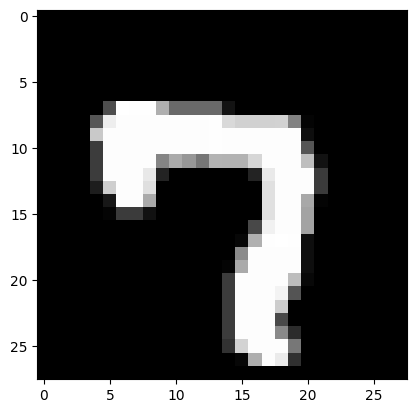

Prediction: 7	Label: 7


In [55]:
def make_prediction(index, X, Y, w1, b1, w2, b2):
    _, _, _, a2 = forward_prop(w1, b1, w2, b2, X)
    predictions = get_predictions(a2)
    
    target_image = X[:, index].reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(target_image, interpolation="nearest")
    plt.show()
    print(f"Prediction: {predictions[index]}\tLabel: {Y[index]}")

random_index = np.random.randint(len(X_train), size=1)[0]
make_prediction(random_index, X_train, Y_train, w1, b1, w2, b2)